In [1]:
import matplotlib.pyplot as plt
from numpy.random import binomial
import numpy as np
from PIL import Image
import cv2
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from numpy.random import randint
from sklearn.utils.extmath import randomized_svd
from tqdm import tqdm_notebook
from sklearn.preprocessing import normalize
from seaborn import heatmap

## Data Description

In [2]:
np.random.seed(seed=42)

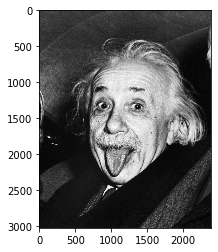

In [3]:
img = Image.open('image.jpg')
gray = cv2.cvtColor(np.array(img),cv2.COLOR_RGB2BGR)
plt.imshow(gray)

In [4]:
data = np.array(img).astype(float)
SS = StandardScaler()
normalized_data = SS.fit_transform(data)
normalized_data[normalized_data==0.0] = 1e-10 #Different from np.nan

In [5]:
def generate_train(img,percentage):
    ind = binomial(1,percentage,(3029, 2390)).astype('float')
    ind[ind==0] = np.nan
    return img*ind

In [6]:
X_train_1 = generate_train(normalized_data,0.001)
X_train_2 = generate_train(normalized_data,0.01)
X_train_3 = generate_train(normalized_data,0.05)
X_train_4 = generate_train(normalized_data,0.1)

In [7]:
X_test_1 = normalized_data.copy()
X_test_1[~np.isnan(X_train_1)] = np.nan
X_test_2 = normalized_data.copy()
X_test_2[~np.isnan(X_train_2)] = np.nan
X_test_3 = normalized_data.copy()
X_test_3[~np.isnan(X_train_3)] = np.nan
X_test_4 = normalized_data.copy()
X_test_4[~np.isnan(X_train_4)] = np.nan

## Methodology and Deliverables

### True SVD

In [8]:
svd = TruncatedSVD(
    n_components=10,
    random_state=42,
    algorithm='randomized'
)

In [9]:
def show(true_matrix):
    color = cv2.cvtColor(true_matrix.astype('uint8'),cv2.COLOR_RGB2BGR)
    plt.imshow(color)
    plt.show()

In [10]:
true_svd = svd.fit_transform(normalized_data)

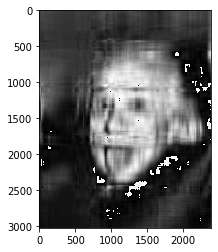

In [11]:
true_matrix = SS.inverse_transform(svd.inverse_transform(true_svd))
show(true_matrix)

In [12]:
def subsample_eigen(normalized_data = normalized_data):
    normalized_data[np.isnan(normalized_data)] = 0
    U,Sigma,V = randomized_svd(csr_matrix(normalized_data), n_components = 10, transpose=False,random_state=42)
    return U,Sigma,V.T

In [13]:
U_true, Sigma_true, V_true = subsample_eigen(normalized_data)

### Random Projection SVD algorithm

#### Calculate the mean bias and standard deviation of your predictions as a function of the sparsity s

In [14]:
def subsample_recover(normalized_data = normalized_data):
    normalized_data[np.isnan(normalized_data)] = 0
    svdx = svd.fit_transform(csr_matrix(normalized_data))
    matrixx = SS.inverse_transform(svd.inverse_transform(svdx))
    show(matrixx)
    return matrixx

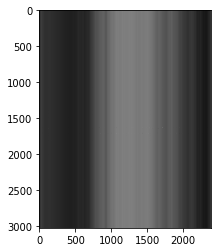

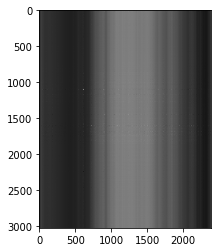

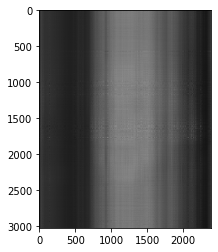

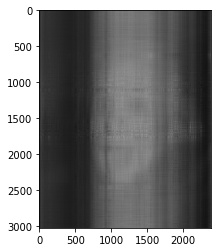

In [15]:
X_predict_1 = subsample_recover(normalized_data = X_train_1.copy())
X_predict_2 = subsample_recover(normalized_data = X_train_2.copy())
X_predict_3 = subsample_recover(normalized_data = X_train_3.copy())
X_predict_4 = subsample_recover(normalized_data = X_train_4.copy())

#### mean bias

In [16]:
mean_bias_1 = np.nanmean(np.abs(SS.inverse_transform(X_test_1) - X_predict_1))
mean_bias_2 = np.nanmean(np.abs(SS.inverse_transform(X_test_2) - X_predict_2))
mean_bias_3 = np.nanmean(np.abs(SS.inverse_transform(X_test_3) - X_predict_3))
mean_bias_4 = np.nanmean(np.abs(SS.inverse_transform(X_test_4) - X_predict_4))
mean_bias_1,mean_bias_2,mean_bias_3,mean_bias_4

(48.07718376917237, 47.77554080954368, 46.0845887262706, 43.905989918508624)

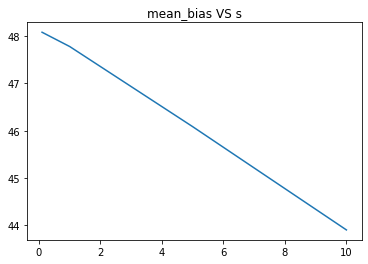

In [17]:
_ = plt.title('mean_bias VS s')
_ = plt.plot((0.1,1,5,10),(mean_bias_1,mean_bias_2,mean_bias_3,mean_bias_4))

#### standard deviation

In [18]:
standard_deviation_1 = np.nanstd(SS.inverse_transform(X_test_1) - X_predict_1)
standard_deviation_2 = np.nanstd(SS.inverse_transform(X_test_2) - X_predict_2)
standard_deviation_3 = np.nanstd(SS.inverse_transform(X_test_3) - X_predict_3)
standard_deviation_4 = np.nanstd(SS.inverse_transform(X_test_4) - X_predict_4)
standard_deviation_1,standard_deviation_2,standard_deviation_3,standard_deviation_4

(60.03269273201176, 59.65885483259644, 57.58762180554774, 54.896228391795034)

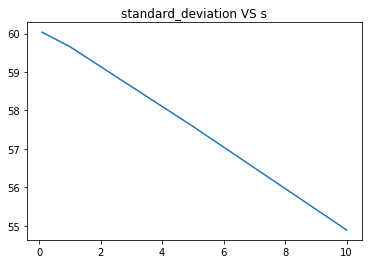

In [19]:
_ = plt.title('standard_deviation VS s')
_ = plt.plot((0.1,1,5,10),(standard_deviation_1,standard_deviation_2,standard_deviation_3,standard_deviation_4))

####  Compare the top K SVD eigenvalues/vectors of with the top K eigenvalues/vectors from of from the previous section. 

In [20]:
U_1, Sigma_1, V_1 = subsample_eigen(X_train_1.copy())
U_2, Sigma_2, V_2 = subsample_eigen(X_train_2.copy())
U_3, Sigma_3, V_3 = subsample_eigen(X_train_3.copy())
U_4, Sigma_4, V_4 = subsample_eigen(X_train_4.copy())

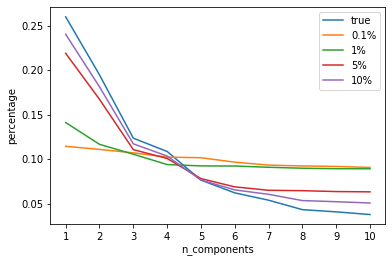

In [21]:
_ = plt.plot(Sigma_true/Sigma_true.sum(),label = 'true')
_ = plt.plot(Sigma_1/Sigma_1.sum(), label = '0.1%')
_ = plt.plot(Sigma_2/Sigma_2.sum(), label = '1%')
_ = plt.plot(Sigma_3/Sigma_3.sum(), label = '5%')
_ = plt.plot(Sigma_4/Sigma_4.sum(), label = '10%')
_ = plt.legend()
_ = plt.xticks(np.arange(10),labels = np.arange(1,11))
_ = plt.xlabel('n_components')
_ = plt.ylabel('percentage')

In [22]:
def calculate_cosine_distance(true,train):
    cosine_distance = []
    for i in range(10):
        for j in range(10):
            cosine_distance.append(np.dot(true[:,i],train[:,j]))
    return np.array(cosine_distance).reshape(10,10)

In [23]:
cosine_distance_U_1 = np.trace(calculate_cosine_distance(U_true,U_1))/10
cosine_distance_U_2 = np.trace(calculate_cosine_distance(U_true,U_2))/10
cosine_distance_U_3 = np.trace(calculate_cosine_distance(U_true,U_3))/10
cosine_distance_U_4 = np.trace(calculate_cosine_distance(U_true,U_4))/10

In [24]:
cosine_distance_V_1 = np.trace(calculate_cosine_distance(V_true,V_1))/10
cosine_distance_V_2 = np.trace(calculate_cosine_distance(V_true,V_2))/10
cosine_distance_V_3 = np.trace(calculate_cosine_distance(V_true,V_3))/10
cosine_distance_V_4 = np.trace(calculate_cosine_distance(V_true,V_4))/10

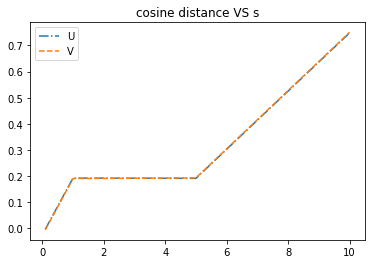

In [25]:
_ = plt.title('cosine distance VS s')
_ = plt.plot((0.1,1,5,10),(cosine_distance_U_1,cosine_distance_U_2,cosine_distance_U_3,cosine_distance_U_4)
             ,label = 'U',linestyle = '-.')
_ = plt.plot((0.1,1,5,10),(cosine_distance_V_1,cosine_distance_V_2,cosine_distance_V_3,cosine_distance_V_4)
             ,label = 'V',linestyle = '--')
_ = plt.legend()

## Sparse-SVD Gradient Descent algorithm

In [26]:
def svd_solve(X, K, lrate = 0.01, C = 0.01,range_n=25):
    U = 0.1*np.random.rand(3029,K)/np.sqrt(10)
    V = 0.1*np.random.rand(2390,K)/np.sqrt(10)
    Train = X.copy()
    Train[np.isnan(Train)] = 0
    i_index = Train.nonzero()[0]
    j_index = Train.nonzero()[1]
    for m in tqdm_notebook(range(range_n)):
        for index in zip(i_index,j_index):
            i = index[0]
            j = index[1]        
            err = Train[i,j]-np.dot(U[i,:],V[j,:])
            U[i,:] = U[i,:] + lrate*(err*V[j,:]-C*U[i,:])
            V[j,:] = V[j,:] + lrate*(err*U[i,:]-C*V[j,:])
        print("MSE:",np.nanmean(np.array(X-np.matrix(U)*np.matrix(V).T)**2))
    return U,V

In [27]:
U_GD_1, V_GD_1 = svd_solve(X_train_1, 10,lrate = 0.1,range_n=20)

MSE: 0.99856013269018
MSE: 0.995634194364737
MSE: 0.9899491472274417
MSE: 0.9778031895348004
MSE: 0.9522645109400887
MSE: 0.9070394037089846
MSE: 0.8459367132640222
MSE: 0.7735841000776787
MSE: 0.6930941999136753
MSE: 0.6088344840292569
MSE: 0.5257203185247737
MSE: 0.4483646899602084
MSE: 0.37887339054178837
MSE: 0.3176813716254427
MSE: 0.26458748882526295
MSE: 0.2191079674262448
MSE: 0.1805812051200561
MSE: 0.14826559698971095
MSE: 0.12142563915458324
MSE: 0.09935219311094709



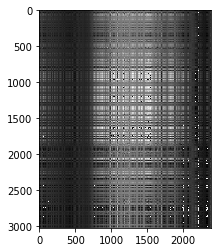

In [28]:
show(SS.inverse_transform(np.dot(U_GD_1,V_GD_1.T)))

In [29]:
U_GD_2, V_GD_2 = svd_solve(X_train_2, 10,lrate = 0.05,range_n=20)

MSE: 0.9925459681638397
MSE: 0.9679876035801778
MSE: 0.8614318189998451
MSE: 0.6777895040539297
MSE: 0.6008608163069262
MSE: 0.5842728893638985
MSE: 0.5720878770437126
MSE: 0.5485185058552668
MSE: 0.4983157844746306
MSE: 0.4169852856254693
MSE: 0.3347868743284121
MSE: 0.2769833865670064
MSE: 0.23677962707593692
MSE: 0.2053592498697956
MSE: 0.17967513305391836
MSE: 0.15872076028844356
MSE: 0.1417715913476055
MSE: 0.1280881611755674
MSE: 0.11698058143057607
MSE: 0.10787286901396449



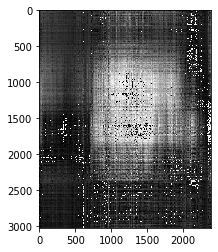

In [30]:
show(SS.inverse_transform(np.dot(U_GD_2,V_GD_2.T)))

In [31]:
U_GD_3, V_GD_3 = svd_solve(X_train_3, 10,lrate = 0.01,range_n=20)

MSE: 0.9979906656271997
MSE: 0.9817422858444689
MSE: 0.9122532796522056
MSE: 0.7511432976145241
MSE: 0.640975350802055
MSE: 0.6216199756605423
MSE: 0.6187151733917186
MSE: 0.6162305624289415
MSE: 0.6106473693139217
MSE: 0.5945739208616676
MSE: 0.5524705766108748
MSE: 0.4795868950672451
MSE: 0.41937352132421085
MSE: 0.39591664213859656
MSE: 0.3858294214127807
MSE: 0.3740311644340187
MSE: 0.3551175647879127
MSE: 0.32788720334934973
MSE: 0.2966871623861585
MSE: 0.26906525033952977



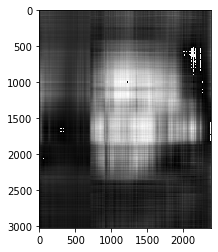

In [32]:
show(SS.inverse_transform(np.dot(U_GD_3,V_GD_3.T)))

In [33]:
U_GD_4, V_GD_4 = svd_solve(X_train_4, 10,lrate = 0.01,range_n=25)

MSE: 0.9657177013356492
MSE: 0.7199776238926693
MSE: 0.6426188190080295
MSE: 0.6369132239570651
MSE: 0.6040846698116753
MSE: 0.4840596470352268
MSE: 0.41768560986092024
MSE: 0.39224960847605994
MSE: 0.3419101508590613
MSE: 0.2884715539142616
MSE: 0.2549781178116969
MSE: 0.23888705051965997
MSE: 0.2282240855616901
MSE: 0.21716868866207217
MSE: 0.20814674346834067
MSE: 0.20192070966677406
MSE: 0.19611471752475385
MSE: 0.1890409794560681
MSE: 0.18103414457451575
MSE: 0.17383415982419356
MSE: 0.16876797523441167
MSE: 0.16565729808454893
MSE: 0.16360801757045706
MSE: 0.16190803563304368
MSE: 0.16017645147863446



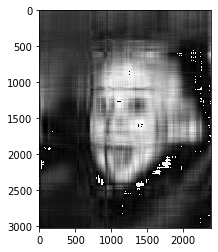

In [34]:
show(SS.inverse_transform(np.dot(U_GD_4,V_GD_4.T)))

### average cosine distance

In [35]:
U_GD_1_re,Sigma_GD_1,V_GD_1_re = subsample_eigen(np.dot(U_GD_1,V_GD_1.T))
U_GD_2_re,Sigma_GD_2,V_GD_2_re = subsample_eigen(np.dot(U_GD_2,V_GD_2.T))
U_GD_3_re,Sigma_GD_3,V_GD_3_re = subsample_eigen(np.dot(U_GD_3,V_GD_3.T))
U_GD_4_re,Sigma_GD_4,V_GD_4_re = subsample_eigen(np.dot(U_GD_4,V_GD_4.T))

In [36]:
GD_cosine_distance_U_1 = np.abs(np.trace(calculate_cosine_distance(U_1,U_GD_1_re))/10)
GD_cosine_distance_U_2 = np.abs(np.trace(calculate_cosine_distance(U_2,U_GD_2_re))/10)
GD_cosine_distance_U_3 = np.abs(np.trace(calculate_cosine_distance(U_3,U_GD_3_re))/10)
GD_cosine_distance_U_4 = np.abs(np.trace(calculate_cosine_distance(U_4,U_GD_4_re))/10)

In [37]:
GD_cosine_distance_V_1 = np.abs(np.trace(calculate_cosine_distance(V_1,V_GD_1_re))/10)
GD_cosine_distance_V_2 = np.abs(np.trace(calculate_cosine_distance(V_2,V_GD_2_re))/10)
GD_cosine_distance_V_3 = np.abs(np.trace(calculate_cosine_distance(V_3,V_GD_3_re))/10)
GD_cosine_distance_V_4 = np.abs(np.trace(calculate_cosine_distance(V_4,V_GD_4_re))/10)

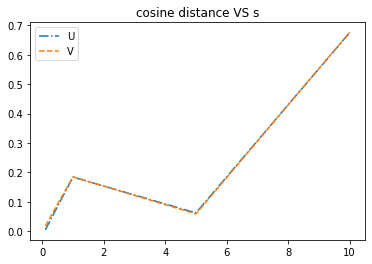

In [38]:
_ = plt.title('cosine distance VS s')
_ = plt.plot((0.1,1,5,10),(GD_cosine_distance_U_1,GD_cosine_distance_U_2,GD_cosine_distance_U_3,GD_cosine_distance_U_4)
             ,label = 'U',linestyle = '-.')
_ = plt.plot((0.1,1,5,10),(GD_cosine_distance_V_1,GD_cosine_distance_V_2,GD_cosine_distance_V_3,GD_cosine_distance_V_4)
             ,label = 'V',linestyle = '--')
_ = plt.legend()

### Choose K_max

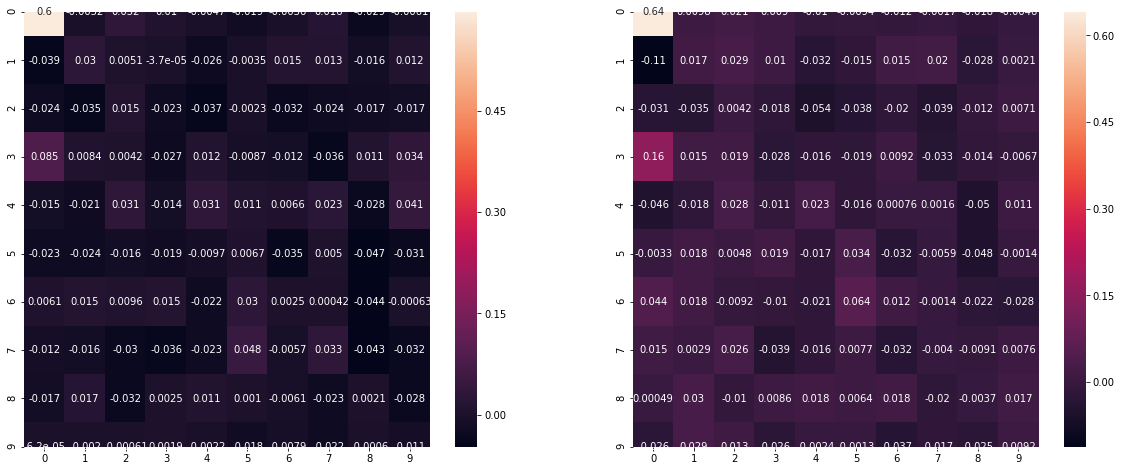

In [39]:
fig,axes = plt.subplots(1,2,figsize=(20,8))
heatmap(calculate_cosine_distance(U_true,U_GD_1_re),annot=True,ax=axes[0])
heatmap(calculate_cosine_distance(V_true,V_GD_1_re),annot=True,ax=axes[1])

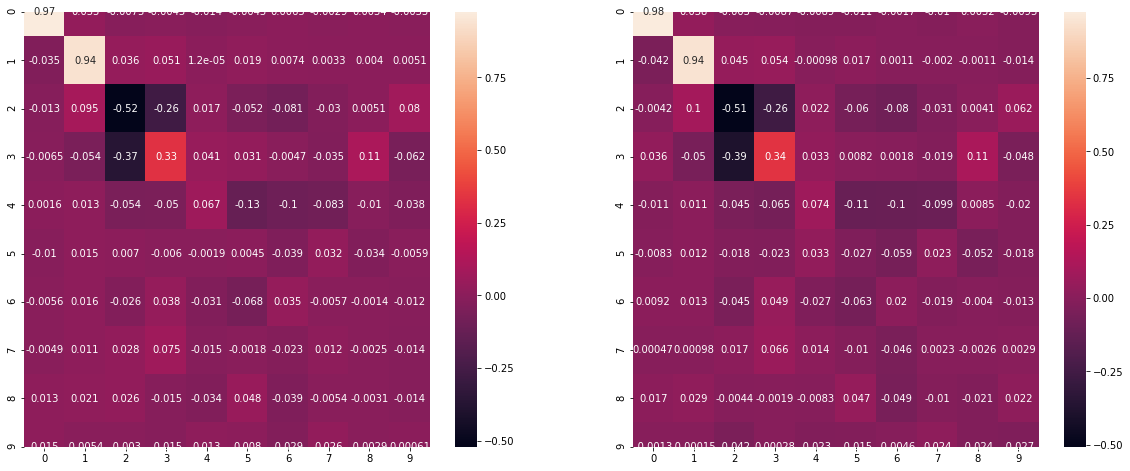

In [40]:
fig,axes = plt.subplots(1,2,figsize=(20,8))
heatmap(calculate_cosine_distance(U_true,U_GD_2_re),annot=True,ax=axes[0])
heatmap(calculate_cosine_distance(V_true,V_GD_2_re),annot=True,ax=axes[1])

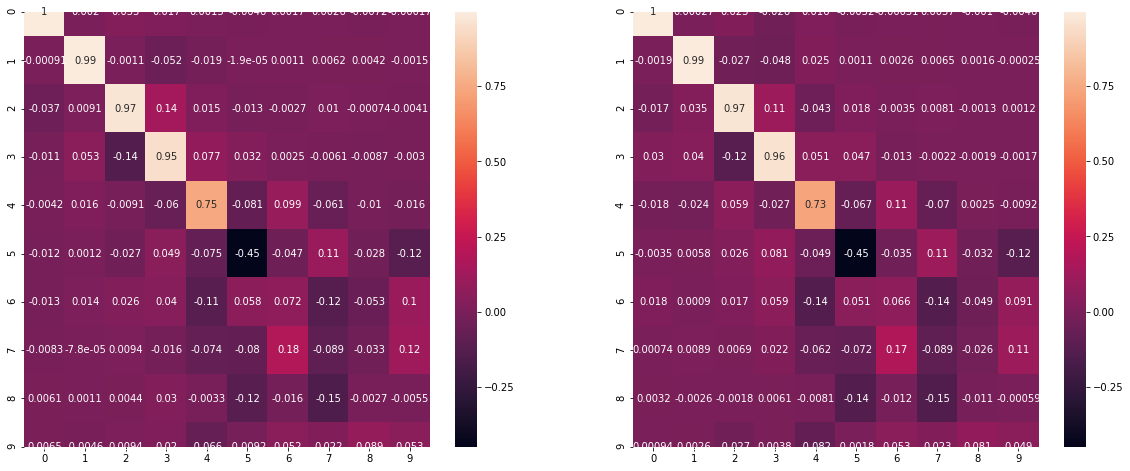

In [41]:
fig,axes = plt.subplots(1,2,figsize=(20,8))
heatmap(calculate_cosine_distance(U_true,U_GD_3_re),annot=True,ax=axes[0])
heatmap(calculate_cosine_distance(V_true,V_GD_3_re),annot=True,ax=axes[1])

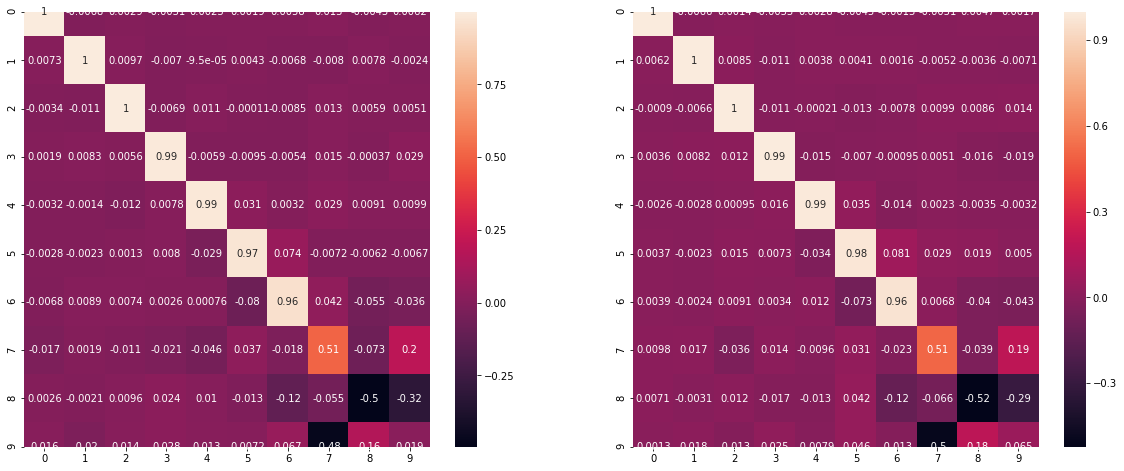

In [42]:
fig,axes = plt.subplots(1,2,figsize=(20,8))
heatmap(calculate_cosine_distance(U_true,U_GD_4_re),annot=True,ax=axes[0])
heatmap(calculate_cosine_distance(V_true,V_GD_4_re),annot=True,ax=axes[1])

For s=0.1%, K_max=1
For s=1%, K_max=4
For s=5%, K_max=4, but the general cosine similarity becomes larger.
For s=10%, K_max=9

### reconstructed image

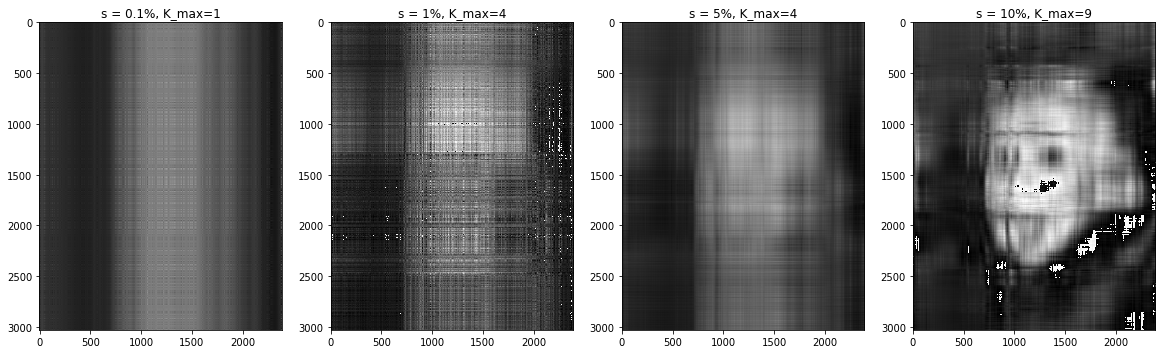

In [43]:
fig,axes = plt.subplots(1,4,figsize=(20,8))
axes[0].set_title('s = 0.1%, K_max=1')
axes[1].set_title('s = 1%, K_max=4')
axes[2].set_title('s = 5%, K_max=4')
axes[3].set_title('s = 10%, K_max=9')
axes[0].imshow(cv2.cvtColor(SS.inverse_transform(np.dot(U_GD_1[:,0:1],
                                                        V_GD_1[:,0:1].T)).astype('uint8'),cv2.COLOR_RGB2BGR))
axes[1].imshow(cv2.cvtColor(SS.inverse_transform(np.dot(U_GD_2[:,0:4],
                                                        V_GD_2[:,0:4].T)).astype('uint8'),cv2.COLOR_RGB2BGR))
axes[2].imshow(cv2.cvtColor(SS.inverse_transform(np.dot(U_GD_3[:,0:4],
                                                        V_GD_3[:,0:4].T)).astype('uint8'),cv2.COLOR_RGB2BGR))
axes[3].imshow(cv2.cvtColor(SS.inverse_transform(np.dot(U_GD_4[:,0:9],
                                                        V_GD_4[:,0:9].T)).astype('uint8'),cv2.COLOR_RGB2BGR))

## Which of the two models is better and why?

When the data set is small or the s is small, I would like to use random projection TruncatedSVD method. Because the result is better and it will not consume so much time.

When the data set is big or the s is large, I would like to use Gradient descent method because it well take a lot of time to do the inverse of the matrix.